In [1]:
from gensim.models.word2vec import LineSentence
import itertools
sentences_legal = list(LineSentence('tokens_legal.txt'))
sentences_lit = list(LineSentence('tokens_literary.txt'))

# combine them into a single list
combined_sentences = sentences_legal + sentences_lit


In [2]:
from gensim.models import Word2Vec

# Train a CBOW model
model_cbow = Word2Vec(combined_sentences, vector_size=100, window=5, min_count=1, sg=0, epochs=10)

# Train a Skip-gram model
model_sg = Word2Vec(combined_sentences, vector_size=100, window=5, min_count=1, sg=1, epochs=10)

# Save the models to files for later use
model_cbow.save("legal_cbow.model")
model_sg.save("legal_skipgram.model")


In [3]:
# test similarity on (choose words present in the corpus)
test_words = ["court", "and"]  # one word likely from legal context, one from literary context

for w in test_words:
    if w in model_cbow.wv:
        sim_cbow = model_cbow.wv.most_similar(w, topn=5)
        sim_sg   = model_sg.wv.most_similar(w, topn=5)
        print(f"Top 5 similar words to '{w}' (CBOW): {sim_cbow}")
        print(f"Top 5 similar words to '{w}' (Skip-gram): {sim_sg}\n")


Top 5 similar words to 'court' (CBOW): [('decision', 0.9931953549385071), ('further', 0.9901190400123596), ('describ', 0.9870098233222961), ('vest', 0.9864450693130493), ('Judiciary', 0.9864046573638916)]
Top 5 similar words to 'court' (Skip-gram): [('Constitution', 0.9180321097373962), ('courts', 0.9132628440856934), ('decision', 0.9064301252365112), ('bill', 0.9008476138114929), ('judiciary', 0.8866021037101746)]

Top 5 similar words to 'and' (CBOW): [('follow', 0.9886744618415833), ('sat', 0.9862837791442871), ('up', 0.9851400852203369), ('land', 0.9795961976051331), ('through', 0.9782225489616394)]
Top 5 similar words to 'and' (Skip-gram): [('whil', 0.7923396825790405), ('soft', 0.790145754814148), ('near', 0.7895819544792175), ('across', 0.7812986969947815), ('tears', 0.780405580997467)]



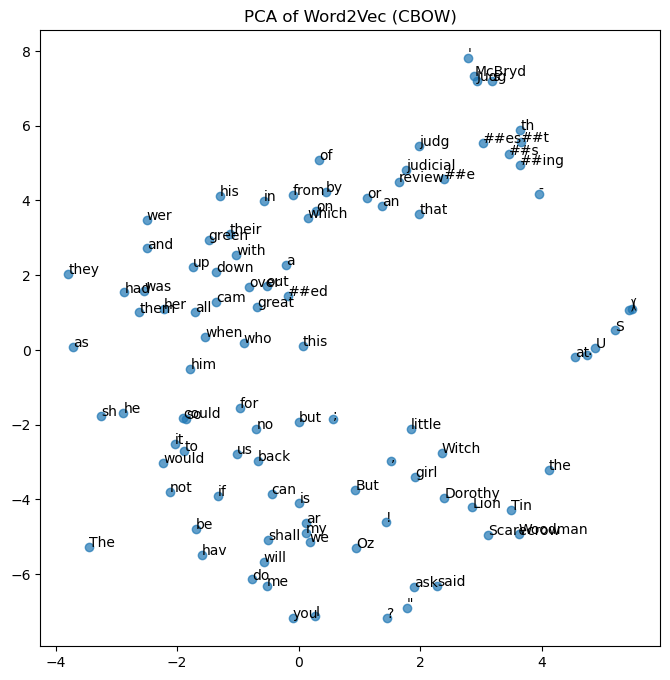

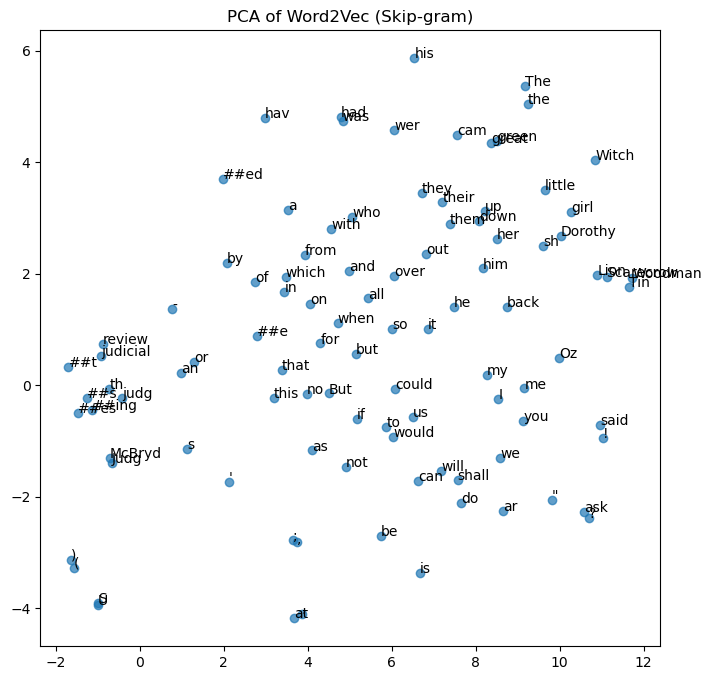

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

def plot_2d_embeddings(model, title, top_n=100):
    """
    Projects the top_n frequent words in the model's vocabulary to 2D using PCA,
    and then plots them using matplotlib.
    """
    vocab_words = list(model.wv.index_to_key[:100])  # top 100 words by frequency
    vectors = model.wv[vocab_words]  # shape: (100, 100)
    
    tsne = TSNE(n_components=2, random_state=42)
    vectors_2d = tsne.fit_transform(vectors)
    
    # Plot the 2D points
    plt.figure(figsize=(8,8))
    plt.scatter(vectors_2d[:,0], vectors_2d[:,1], alpha=0.7)
    # Annotate points with words to see which is which
    for i, word in enumerate(vocab_words):
        x, y = vectors_2d[i,0], vectors_2d[i,1]
        plt.annotate(word, (x, y))
    plt.title(title)
    plt.savefig(title)
    plt.show()

# Plot the CBOW embeddings
plot_2d_embeddings(model_cbow, title="PCA of Word2Vec (CBOW)")

# Plot the Skip-gram embeddings
plot_2d_embeddings(model_sg, title="PCA of Word2Vec (Skip-gram)")

In [11]:
###########################################
# PART II: Legal Hallucination Detection
###########################################

import re
import numpy as np
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

############################
# TOKENIZATION
############################

def extract_case_citations(text):
    """
    Extract case citations or references from the LLM response.
    """
    # regex for capturing references like 'CaseName v. SomeOther, 123 U.S. 456'
    pattern = r"([A-Z][a-zA-Z]+(?:\s[A-Z][a-zA-Z]+)*\sv\.\s[A-Z][a-zA-Z]+(?:\s[A-Z][a-zA-Z]+)*[^\n,]*)"
    matches = re.findall(pattern, text)
    return matches

def tokenize_with_transformers(text, tokenizer):
    """
    Tokenize the input text using a Hugging Face Transformers-based tokenizer.
    Returns a list of tokens.
    """
    tokens = tokenizer.tokenize(text)
    return tokens

############################
# VECTOR DATABASE
############################

class SimpleVectorDB:
    """
    A minimal in-memory 'vector database' that stores text and corresponding embeddings.
    Provides a similarity search via cosine similarity.
    """
    def __init__(self):
        self.texts = []
        self.vectors = []

    def add(self, text, vector):
        self.texts.append(text)
        self.vectors.append(vector)

    def similarity_search(self, query_vector, top_k=5):
        """
        Returns the top_k most similar texts based on cosine similarity.
        """
        scores = []
        for idx, vec in enumerate(self.vectors):
            sim = cosine_similarity(query_vector, vec)
            scores.append((self.texts[idx], sim))
        # sort by descending similarity
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

############################
# MAIN PIPELINE
############################

def main():
    with open("Model-output.txt", "r", encoding="utf-8") as f:
        model_output_text = f.read()

    with open("combined-text.txt", "r", encoding="utf-8") as f:
        combined_db_text = f.read()

    # Extract the citations from the LLM response using regex
    case_citations = extract_case_citations(model_output_text)

    # intialize tokenizer
    hf_tokenizer_name = "bert-base-uncased"
    hf_tokenizer = AutoTokenizer.from_pretrained(hf_tokenizer_name)

    # tokenize entire LLM response using huggingface transformers
    tokens_llm = tokenize_with_transformers(model_output_text, hf_tokenizer)

    # SentenceTransformer model for vectorization
    model_name = "all-MiniLM-L6-v2"
    embedder = SentenceTransformer(model_name)

    # Create a vector DB
    cases = combined_db_text.split("\n\n\n\n")  # split on newlines

    vector_db = SimpleVectorDB()

    # Embed and store each case in the vector DB
    for case_text in cases:
        case_vector = embedder.encode(case_text, convert_to_numpy=True)
        vector_db.add(case_text, case_vector)

    # DETECT TYPE 1 HALLUCINATIONS: Nonexistent Citation 
    # We'll check if the citation is in combined_db_text. If not, do a vector match check.
    hallucinated_cases_type1 = []
    for citation in case_citations:
        if citation not in combined_db_text:
            # embed the citation and do a vector similarity search
            citation_vector = embedder.encode(citation, convert_to_numpy=True)
            top_matches = vector_db.similarity_search(citation_vector, top_k=1)
            best_match_text, best_match_sim = top_matches[0]
            if best_match_sim < 0.7:  # threshold for 'close' match, adjust as needed
                hallucinated_cases_type1.append(citation)

    print("Type 1 (Nonexistent) Hallucinations:", hallucinated_cases_type1)

    # DETECT TYPE 2 HALLUCINATIONS: Misrepresented Case
    # If the citation is found in combined_db_text, we check if it's misrepresented.
    hallucinated_cases_type2 = []
    for citation in case_citations:
        if citation in combined_db_text:
            # assume there's exactly one matching case text, found by searching in 'cases'
            snippet_vector = embedder.encode(citation, convert_to_numpy=True)

            actual_case_text = None
            for c_text in cases:
                if citation in c_text:
                    actual_case_text = c_text
                    break

            if actual_case_text:
                actual_case_vector = embedder.encode(actual_case_text, convert_to_numpy=True)
                sim_score = cosine_similarity(snippet_vector, actual_case_vector)
                # low similarity => suspected misrepresentation
                if sim_score < 0.5:
                    hallucinated_cases_type2.append((citation, sim_score))

    print("Type 2 (Misrepresented) Hallucinations:", hallucinated_cases_type2)


if __name__ == "__main__":
    main()


Token indices sequence length is longer than the specified maximum sequence length for this model (2553 > 512). Running this sequence through the model will result in indexing errors


Type 1 (Nonexistent) Hallucinations: ['See Hurwitz v. United States', 'Messenger v. Gruner Key Symbol Jahr Printing and Publ’g', 'Andrea v. Fakename', 'See Weil v. Johnson', 'Piskac v. Shapiro', 'Lemerond v. Twentieth Century Fox Film Corp.', 'Finger v. Omni Publs. Intl.', 'In Candelaria v. Spurlock', 'See Spurlock v. Candelaria']
Type 2 (Misrepresented) Hallucinations: [('See Gautier v. Pro-Football', 0.057923667), ('Delan v. CBS', 0.24633962), ('Arrington v. New York Times Co.', 0.28837228)]
